In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import equinox as eqx
import optax

import numpyro.distributions as dist

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

from IPython.display import clear_output

from typing import List, Tuple
from jaxtyping import Int, Array, Float, PyTree

/disks/data/SAM/neural-process-example/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Defining the MLP model, to be used as a batch MLP
# Inherit the eqx.Module class

class MLP(eqx.Module):

    layers: List

    def __init__(
        self,
        layer_sizes: List,
        key: jax.random.PRNGKey,
    ):

        self.layers = []

        for (feat_in, feat_out) in zip(layer_sizes[:-2], layer_sizes[1:-1]):
            key, subkey = jax.random.split(key)

            self.layers.append(
                eqx.nn.Linear(feat_in, feat_out, use_bias=True, key=subkey)
            )  # fully-connected layer
            self.layers.append(
                jnp.tanh
            )  # activation function

        key, subkey = jax.random.split(key)

        self.layers.append(
            eqx.nn.Linear(layer_sizes[-2], layer_sizes[-1], use_bias=True, key=subkey)
        )  # final layer

    # __call__ turns an instance of this class into a callable object, which behaves like a function
    def __call__(
        self,
        x: Float[Array, "1 1"],
    ) -> Float[Array, "1 1"]:

        # apply each layer in sequence
        for layer in self.layers:
            x = layer(x)

        return x

In [3]:
class CNP(eqx.Module):

    layers: list

    def __init__(
            self,
            encoder: MLP,
            decoder: MLP,
    ):

        self.layers = [encoder, decoder]


    def __call__(
            self,
            x_context: Float[Array, "batch n_context 1"],
            y_context: Float[Array, "batch n_context 1"],
            x_target: Float[Array, "batch n_target 1"],
    ) -> dist.Distribution:

        # get number of target points
        _, n_target, _ = x_target.shape

        # encoder step
        encoded_rep = self._encode(x_context, y_context)  # (batch_size, 1, encoder_dim)

        # tile sample before passing to the decoder
        representation = self._tile(encoded_rep, n_target)  # (batch_size, n_target, encoder_dim)

        # decoder step to produce distribution of functions
        distribution = self._decode(representation, x_target)

        return distribution


    def _encode(
            self,
            x_context: Float[Array, "batch n_context 1"],
            y_context: Float[Array, "batch n_context 1"],
    ) -> dist.Distribution:

        xy_context = jnp.concatenate([x_context, y_context], axis=-1)  # (batch_size, n_context, 2)

        return jnp.mean(self._encode_mlp(xy_context), axis=1, keepdims=True)  # (batch_size, 1, encoder_dim)


    def _encode_mlp(
            self,
            xy_context: Float[Array, "batch n_context 2"],
    ) -> Float[Array, "batch n_context encoder_dim"]:

        return jax.vmap(jax.vmap(self.layers[0]))(xy_context)


    def _tile(
            self,
            z_latent: Float[Array, "batch 1 encoder_dim"],
            n_target: Int,
    ) -> Float[Array, "batch n_target encoder_dim"]:

        return jnp.tile(z_latent, [1, n_target, 1])


    def _decode(
            self,
            representation: Float[Array, "batch n_target encoder_dim"],
            x_target: Float[Array, "batch n_target 1"],
    ) -> dist.Distribution:

        representation = jnp.concatenate([representation, x_target], axis=-1)  # (batch_size, n_target, encoder_dim + 1)

        mlp_out = jax.vmap(jax.vmap(self.layers[1]))(representation)  # (batch_size, n_target, 1)

        mu, sigma = jnp.split(mlp_out, 2, axis=-1)  # each (batch_size, n_target, 1)

        sigma = 0.1 + 0.9 * jax.nn.softplus(sigma)

        return dist.Normal(loc=mu, scale=sigma)

In [4]:
def loss(
        model: CNP,
        x_context: Float[Array, "batch n_context 1"],
        y_context: Float[Array, "batch n_context 1"],
        x_target: Float[Array, "batch n_context 1"],
        y_target: Float[Array, "batch n_context 1"],
) -> Float[Array, ""]:

    distribution = model(x_context, y_context, x_target)

    return - np.mean(distribution.log_prob(y_target))

loss_and_grad = eqx.filter_value_and_grad(loss)

loss = eqx.filter_jit(loss)

In [5]:
@eqx.filter_jit
def split_data(
    keys: List[jax.random.PRNGKey],
    x: Float[Array, "batch n_points 1"],
    y: Float[Array, "batch n_points 1"],
    n_context: Int,
    n_target: Int,
) -> Tuple[Float[Array, "batch n_context 1"], Float[Array, "batch n_context 1"], Float[Array, "batch n_target 1"], Float[Array, "batch n_target 1"]]:

    # def choose_values(
    #     key: jax.random.PRNGKey,
    #     arr: Array,
    #     n: Int,
    # ) -> Array:

    #     rows, cols = arr.shape[0], arr.shape[1]

    #     chosen_values = np.zeros((rows, n, arr.shape[2]))

    #     for i in range(rows):
    #         indices = jax.random.choice(key, cols, (n,), False)
    #         chosen_values[i] = arr[i, indices, :]

    #     return chosen_values

    def choose_values(
            key: jax.random.PRNGKey,
            arr: Array,
            n: Int,
    ) -> Array:

        cols = arr.shape[1]

        indices = jax.random.choice(key, cols, (n,), False)

        return arr[:, indices, :]

    x_context = choose_values(keys[0], x, n_context)
    y_context = choose_values(keys[0], y, n_context)
    x_target = choose_values(keys[1], x, n_target)
    y_target = choose_values(keys[1], y, n_target)

    return x_context, y_context, x_target, y_target

In [6]:
def evaluate(
        key: jax.random.PRNGKey,
        model: CNP,
        test_loader: DataLoader,
        n_context: Int,
        n_target: Int,
) -> Float[Array, ""]:

    tot_loss = 0

    for (x, y) in test_loader:
        x, y = x.numpy(), y.numpy()

        key, *subkeys = jax.random.split(key, 3)
        x_context, y_context, x_target, y_target = split_data(subkeys, x, y, n_context, n_target)

        tot_loss += loss(model, x_context, y_context, x_target, y_target)

    return tot_loss / len(test_loader)

In [7]:
def train(
        key: jax.random.PRNGKey,
        model: CNP,
        train_loader: DataLoader,
        test_loader: DataLoader,
        optim: optax.GradientTransformation,
        n_context: Int,
        n_target: Int,
        epochs: Int,
        plot_every: Int,
) -> CNP:

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: CNP,
        opt_state: PyTree,
        x_context: Float[Array, "batch n_context 1"],
        y_context: Float[Array, "batch n_context 1"],
        x_target: Float[Array, "batch n_target 1"],
        y_target: Float[Array, "batch n_target 1"],
    ) -> Tuple[CNP, PyTree, Float]:

        loss_value, grads = loss_and_grad(
            model,
            x_context,
            y_context,
            x_target,
            y_target,
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss_value

    train_losses = []
    test_losses = []
    plot_epochs = []

    # Create a function to update the loss plot
    def update_loss_plot(train_losses, test_losses, plot_epochs):
        clear_output(wait=True)
        plt.figure(figsize=(7, 5))
        plt.plot(plot_epochs, train_losses, 'o-', markevery=[-1], label='train_loss')
        plt.plot(plot_epochs, test_losses, 'o-', markevery=[-1], label='test_loss')
        plt.xlim([0, epochs])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')
        plt.grid(True)
        plt.show()

    for epoch in range(epochs):
        epoch_loss = 0

        for (x, y) in train_loader:
            x, y = x.numpy(), y.numpy()

            key, *subkeys = jax.random.split(key, 3)
            x_context, y_context, x_target, y_target = split_data(subkeys, x, y, n_context, n_target)

            model, opt_state, train_loss = make_step(
                model,
                opt_state,
                x_context,
                y_context,
                x_target,
                y_target,
            )
            epoch_loss += train_loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)

        if (epoch % plot_every) == 0:
            key, subkey = jax.random.split(key, 2)
            test_loss = evaluate(subkey, model, test_loader, n_context, n_target)
            train_losses.append(avg_epoch_loss)
            test_losses.append(test_loss)
            plot_epochs.append(epoch)
            update_loss_plot(train_losses, test_losses, plot_epochs)

    return model

In [8]:
def exponentiated_quadratic_kernel(
    x: Array,
    y: Array,
    sigma: Float=1.0,
    rho: Float=1.0,
) -> Array:

    def _exponentiated_quadratic(x, y, sigma, rho):
        x_e = jnp.expand_dims(x, 1) / rho
        y_e = jnp.expand_dims(y, 0) / rho
        d = jnp.sum(jnp.square(x_e - y_e), axis=-1)
        K = sigma * jnp.exp(-0.5 * d)
        return K

    return _exponentiated_quadratic(x, y, sigma, rho)


def sample_gp(
    key: jax.random.PRNGKey,
    n_imgs: int,
    domain: float,
    grid_steps: int,
    rho: float,
    sigma: float,
) -> Tuple[
    Tuple[np.ndarray, np.ndarray],
    np.ndarray
    ]:

    # generate array between -pi to pi with grid_steps no. of points
    x = jnp.linspace(-domain, domain, grid_steps).reshape(
        (grid_steps, 1)
    )

    ys = []
    for _ in range(n_imgs):
        key, *subkeys = jax.random.split(key, 3)

        K = exponentiated_quadratic_kernel(x, x, sigma, rho)

        y = jax.random.multivariate_normal(
            subkeys[0],
            mean=jnp.zeros(grid_steps),
            cov=K + jnp.diag(jnp.ones(grid_steps)) * np.mean(np.abs(K)) * 1e-6,
        )
        ys.append(y.reshape((1, grid_steps, 1)))

    # repeat x along first axis n_imgs times
    x = np.array(jnp.tile(x, [n_imgs, 1, 1]))  # shape (n_imgs, grid_steps ** 2, 1)
    y = np.array(jnp.vstack(jnp.array(ys)))  # shape (n_imgs, grid_steps ** 2, 1)

    return x, y

In [9]:
def normalize(arr, n):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = 2 * n * (arr - min_val) / (max_val - min_val) - n
    return normalized_arr, min_val, max_val

def unnormalize(normalized_arr, min_val, max_val, n):
    arr = 0.5 * (normalized_arr + n) * (max_val - min_val) / n + min_val
    return arr

def unnormalize_std(normalized_std, min_val, max_val, n):
    std = normalized_std * (max_val - min_val) / (2 * n)
    return std

In [10]:
N_FUNCTIONS = 1024
N_POINTS = 16
RHO = 1.0
SIGMA = 2.0
DOMAIN = 2
NORM_SCALE = 4

SPLIT = 0.8
BATCH_SIZE = 64
N_CONTEXT = 4
N_TARGET = 16

ENCODER_DIM = 128  # latent dimension of the encoder
ENCODER_LAYERS = [2, ENCODER_DIM, ENCODER_DIM, ENCODER_DIM]  # number of neurons in each fully-connected layer
DECODER_LAYERS = [ENCODER_DIM + 1, ENCODER_DIM, ENCODER_DIM, ENCODER_DIM, 2]  # number of neurons in each fully-connected layer
LEARNING_RATE = 3e-4
EPOCHS = 10000
PLOT_EVERY = int(10)  # plot progress during training every PRINT_EVERY epochs

SEED = 5678
key = jax.random.PRNGKey(SEED)

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
key, subkey = jax.random.split(key, 2)
x, y = sample_gp(
    key=subkey,
    n_imgs=N_FUNCTIONS,
    domain=DOMAIN,
    grid_steps=N_POINTS,
    rho=RHO,
    sigma=SIGMA,
)

print(x.shape, y.shape)

(1024, 16, 1) (1024, 16, 1)


In [12]:
y_norm, _, _ = normalize(y, NORM_SCALE)

In [13]:
tensor_x, tensor_y = torch.Tensor(x), torch.Tensor(y_norm)

dataset = TensorDataset(tensor_x, tensor_y)

train_set, test_set = random_split(dataset, [SPLIT, 1 - SPLIT], generator=torch.Generator().manual_seed(SEED + 1))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
dummy_x, dummy_y = next(iter(train_loader))

dummy_x, dummy_y = dummy_x.numpy(), dummy_y.numpy()

print(dummy_x.shape, dummy_y.shape)

(64, 16, 1) (64, 16, 1)


In [15]:
key, *subkeys = jax.random.split(key, 3)
encoder = MLP(ENCODER_LAYERS, subkeys[0])
decoder = MLP(DECODER_LAYERS, subkeys[1])

model = CNP(encoder, decoder)

print(model)

CNP(
  layers=[
    MLP(
      layers=[
        Linear(
          weight=f32[128,2],
          bias=f32[128],
          in_features=2,
          out_features=128,
          use_bias=True
        ),
        <wrapped function tanh>,
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        <wrapped function tanh>,
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        )
      ]
    ),
    MLP(
      layers=[
        Linear(
          weight=f32[128,129],
          bias=f32[128],
          in_features=129,
          out_features=128,
          use_bias=True
        ),
        <wrapped function tanh>,
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        <wrapped 

In [16]:
optim = optax.adamw(LEARNING_RATE)

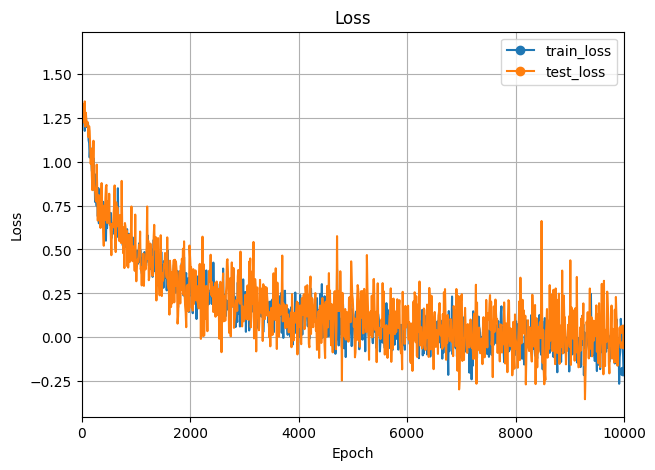

In [17]:
key, subkey = jax.random.split(key, 2)

model = train(
    key,
    model,
    train_loader,
    test_loader,
    optim,
    N_CONTEXT,
    N_TARGET,
    EPOCHS,
    PLOT_EVERY,
)

In [107]:
key, subkey = jax.random.split(key, 2)
x_test, y_test = sample_gp(subkey, 1, DOMAIN, N_POINTS, 1.0, 2.0)

key, *subkeys = jax.random.split(key, 3)
x_test_context, y_test_context, _, _ = split_data(subkeys, x_test, y_test, N_CONTEXT, N_POINTS)

In [108]:
y_preds = model(x_test_context, y_test_context, x_test)

y_mu = jnp.squeeze(y_preds.mean)
y_sigma = jnp.squeeze(jnp.sqrt(y_preds.variance))

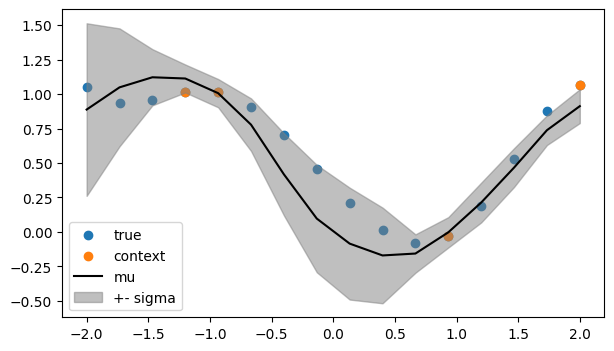

In [109]:
x_plot = np.squeeze(x_test)

fig, ax = plt.subplots(figsize=(7, 4))

ax.scatter(x_plot, jnp.squeeze(y_test), label="true")
ax.scatter(x_test_context, y_test_context, label="context")
ax.plot(x_plot, y_mu, c='k', label='mu')
ax.fill_between(x_plot, y_mu - y_sigma, y_mu + y_sigma, color='grey', alpha=0.5, label="+- sigma")

ax.legend()

plt.show()